# LG (Logistic Regression) — Binary Dormant/Non‑Dormant Scoring & Report Artifacts

이 노트북은 아래를 한 번에 수행합니다.

- 입력: `features_ml_clean.parquet`, `labels.parquet` (및 `split`)
- 학습: Logistic Regression (이진 분류)
- 산출물:
  - `scoring.parquet` *(= predictions_test 역할; test 스플릿 예측 결과)*
  - `model.joblib`, `feature_list.json` *(운영 스코어링 재사용용)*
  - `model_card.json`, `pr_metrics.json`, `topk_metrics.json`, `topk_cutoffs.json`
  - `topk_users_5pct.parquet` *(상위 5% 타겟 리스트)*

주의:
- 누수 방지를 위해 **피처는 `features_ml_clean.parquet` 컬럼만 사용**합니다.
- 이진 라벨은 기본적으로 `m2`를 휴면(1)으로 간주합니다(필요 시 수정).


In [2]:
import json
from pathlib import Path

import numpy as np
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import average_precision_score
import joblib

# =========================================================
# 0) 경로/메타 설정
# =========================================================
PROJECT_ROOT = Path(r"C:\sknfolder\SKN23-2nd-3Team")

DATA_DIR = PROJECT_ROOT / "data" / "processed"
OUT_DIR  = PROJECT_ROOT / "models" / "eval" / "lg"
OUT_DIR.mkdir(parents=True, exist_ok=True)

PATHS = {
    "labels":   DATA_DIR / "labels.parquet",
    "features": DATA_DIR / "features_ml_clean.parquet",
}

for k, p in PATHS.items():
    print(f"{k}: {p} | exists={p.exists()}")

# ---- 모델 카드(팀 템플릿 맞춤) ----
MODEL_ID      = "ml__logreg_lg"
DISPLAY_NAME  = "LogReg(LG)"
CATEGORY      = "ML"
SPLIT         = "test"

# ---- TopK 설정(팀 템플릿 맞춤) ----
K_LIST = [5, 10, 15, 30]
N_SELECTED_RULE = "floor"                # 팀 합의(필요 시 ceil로 변경)
TIE_POLICY      = "sort_and_take_top_n"  # 점수 동점 시: 정렬 후 상위 n개로 고정

# ---- 이진 라벨 정의 ----
# 라벨 컬럼이 문자열(m0/m1/m2)일 때: m2를 휴면(1)로 간주
POS_LABEL_STR = "m2"


labels: C:\sknfolder\SKN23-2nd-3Team\data\processed\labels.parquet | exists=False
features: C:\sknfolder\SKN23-2nd-3Team\data\processed\features_ml_clean.parquet | exists=False


## 1) 데이터 로드 및 병합

- `features`와 `labels`를 `(user_id, anchor_time)`로 inner join
- 타입 정리(문자열/시간)


In [2]:
labels = pd.read_parquet(PATHS["labels"])
features = pd.read_parquet(PATHS["features"])

# 타입 정리
labels["user_id"]   = labels["user_id"].astype(str)
features["user_id"] = features["user_id"].astype(str)

labels["anchor_time"]   = pd.to_datetime(labels["anchor_time"])
features["anchor_time"] = pd.to_datetime(features["anchor_time"])

df = features.merge(labels, on=["user_id", "anchor_time"], how="inner")

print("features:", features.shape)
print("labels:", labels.shape)
print("merged:", df.shape)

# (선택) 키 중복 체크
dup = df.duplicated(subset=["user_id", "anchor_time"]).sum()
print("duplicate (user_id, anchor_time):", dup)


features: (813540, 16)
labels: (813540, 6)
merged: (813540, 20)
duplicate (user_id, anchor_time): 0


In [24]:
print(df.head(1))

     user_id anchor_time  n_events_30d  active_days_30d  n_purchase_30d  \
0  113868975  2020-01-31            17                8               0   

   purchase_ratio  days_since_last_event  days_since_last_purchase  \
0             0.0                0.44691                      31.0   

   brand_concentration_ratio  brand_switch_count_30d  total_spend_30d  \
0                   0.588235                       9              0.0   

   activity_ratio_15d  price_volatility  n_events_7d  visit_regularity  \
0            0.705882               0.0          8.0          1.494799   

   activity_trend home_brand future_brand label  split  
0        0.470588      apple        apple    m0  train  


## 2) 이진 라벨(y) 생성

- 라벨 컬럼을 자동 탐색
- 이미 0/1이면 그대로 사용
- 문자열(m0/m1/m2)이면 기본적으로 `m2`를 1로 매핑


In [3]:
# 라벨 컬럼 후보(프로젝트에 맞게 추가/수정 가능)
label_candidates = ["y_true", "y", "label", "target", "is_dormant", "dormant", "churn", "m"]

label_col = next((c for c in label_candidates if c in df.columns), None)
assert label_col is not None, f"라벨 컬럼을 못 찾았습니다. candidates={label_candidates}"

print("label_col =", label_col, "| unique(head):", pd.Series(df[label_col]).dropna().astype(str).unique()[:10])

def to_binary_label(s: pd.Series, pos_label_str: str = "m2") -> np.ndarray:
    # 1) 이미 0/1 형태면 그대로
    if pd.api.types.is_numeric_dtype(s):
        u = pd.Series(s.dropna().unique()).sort_values().tolist()
        if set(u).issubset({0, 1}):
            return s.fillna(0).astype(int).to_numpy()

    # 2) 문자열 기반 매핑
    s2 = s.astype(str).str.strip().str.lower()
    y = (s2 == str(pos_label_str).strip().lower()).astype(int).to_numpy()
    return y

y = to_binary_label(df[label_col], pos_label_str=POS_LABEL_STR)

# sanity check
u = np.unique(y)
assert set(u).issubset({0, 1}), f"이진 라벨 변환 실패: unique={u}"
assert len(u) == 2, f"라벨이 한 클래스만 존재합니다. unique={u} (라벨 정의/POS_LABEL_STR 확인 필요)"

print("base_rate(=mean y):", float(y.mean()))


label_col = label | unique(head): ['m0' 'm2' 'm1']
base_rate(=mean y): 0.8183592693659808


## 3) 피처 행렬(X) 구성 (누수 방지)

- `features_ml_clean.parquet`의 컬럼 중 `user_id`, `anchor_time` 제외한 14개만 사용
- 숫자형 변환/결측치 처리
- (선택) 상수 컬럼 제거


In [4]:
# 안전: features 파일 기준으로만 feature 목록 고정 (labels 컬럼 섞임 방지)
feature_cols = [c for c in features.columns if c not in ["user_id", "anchor_time"]]
print("n_features:", len(feature_cols))
print(feature_cols)

X = df[feature_cols].copy()

# 비수치형 방어(원칙상 전부 수치여야 함)
for c in X.columns:
    if not pd.api.types.is_numeric_dtype(X[c]):
        X[c] = pd.to_numeric(X[c], errors="coerce")

X = X.fillna(0)

# 상수(정보 0) 컬럼 제거(있으면)
const_cols = [c for c in X.columns if X[c].nunique(dropna=False) <= 1]
if const_cols:
    print("drop constant cols:", const_cols)
    X = X.drop(columns=const_cols)
    feature_cols = [c for c in feature_cols if c not in const_cols]

print("X shape:", X.shape)


n_features: 14
['n_events_30d', 'active_days_30d', 'n_purchase_30d', 'purchase_ratio', 'days_since_last_event', 'days_since_last_purchase', 'brand_concentration_ratio', 'brand_switch_count_30d', 'total_spend_30d', 'activity_ratio_15d', 'price_volatility', 'n_events_7d', 'visit_regularity', 'activity_trend']
X shape: (813540, 14)


## 4) Train/Val/Test 분리

- `split` 컬럼이 `labels`에 있어야 합니다.
- 없으면(혹은 다른 이름이면) 먼저 split 생성 로직을 추가해야 합니다.


In [5]:

assert "split" in df.columns, "df에 split 컬럼이 없습니다. labels.parquet에 split이 있는지 확인하세요."

split = df["split"].astype(str).str.lower().values
train_mask = split == "train"
val_mask   = np.isin(split, ["val", "valid", "validation"])
test_mask  = split == "test"

X_train, y_train = X.loc[train_mask], y[train_mask]
X_val,   y_val   = X.loc[val_mask],   y[val_mask]
X_test,  y_test  = X.loc[test_mask],  y[test_mask]

print("train/val/test:", len(X_train), len(X_val), len(X_test))


train/val/test: 574092 137615 101833


## 5) 모델 학습 (Logistic Regression)

- 이진 분류용 `liblinear` 사용
- 데이터가 불균형이면 `class_weight="balanced"`를 비교 실험해볼 가치가 있습니다.


In [6]:
clf = LogisticRegression(
    solver="liblinear",
    max_iter=2000,
    class_weight=None,   # 불균형 심하면 "balanced"로도 비교
)

clf.fit(X_train, y_train)
print("trained.")

# (선택) val AUPRC를 보고 싶으면
if len(X_val) > 0:
    proba_val = clf.predict_proba(X_val)[:, 1]
    ap_val = float(average_precision_score(y_val, proba_val))
    print("val PR-AUC(AP):", ap_val)


trained.
val PR-AUC(AP): 0.9113325954022002


## 6) Test 예측 결과(scoring.parquet) 생성

`scoring.parquet`는 팀에서 말하는 `predictions_test.parquet` 스키마를 사실상 대체합니다.

필수 컬럼:
- `user_id`, `anchor_time`, `y_true`, `risk_score`


In [7]:
proba_test = clf.predict_proba(X_test)[:, 1]
ap_test = float(average_precision_score(y_test, proba_test))
print("test PR-AUC(AP):", ap_test)

df_test = df.loc[X_test.index, ["user_id", "anchor_time"]].copy()
df_test["risk_score"] = proba_test
df_test["y_true"] = y_test.astype(int)

# 저장(=predictions_test 대체)
SCORING_PATH = OUT_DIR / "scoring.parquet"
df_test.to_parquet(SCORING_PATH, index=False)
print("saved:", SCORING_PATH)

df_test.head()


test PR-AUC(AP): 0.9297780014360004
saved: C:\SKNfolder\SKN23-2nd-3Team\models\eval\lg\scoring.parquet


,user_id,anchor_time,risk_score,y_true
2,113868975,2020-03-31,0.902413,0
22,273568916,2020-03-31,0.940503,1
43,299358698,2020-03-31,0.793854,1
75,322630864,2020-03-31,0.839068,1
79,327023582,2020-03-31,0.807091,1


## 7) TopK 지표 + 컷오프 + JSON 산출물 저장 (팀 템플릿)

- PR-AUC: `pr_metrics.json`
- Base rate + Precision/Recall/Lift@K: `topk_metrics.json`
- n_total + n_selected + t_k: `topk_cutoffs.json`
- 모델 메타: `model_card.json`
- 상위 5% 대상자 리스트: `topk_users_5pct.parquet`

주의:
- `N_SELECTED_RULE="floor"`로 **n_selected를 고정**합니다(팀 기준).
- `t_k`는 **정렬 후 n_selected번째 점수**입니다.


In [8]:
df_sorted = df_test.sort_values("risk_score", ascending=False).reset_index(drop=True)

n_total = int(len(df_sorted))
base_rate = float(df_sorted["y_true"].mean())

pr_auc = float(average_precision_score(df_sorted["y_true"].values, df_sorted["risk_score"].values))

def compute_topk_block(df_sorted: pd.DataFrame, k_pct: int, n_selected_rule: str = "floor"):
    n_total = len(df_sorted)

    if n_selected_rule == "floor":
        n_selected = int(np.floor(n_total * (k_pct / 100.0)))
    elif n_selected_rule == "ceil":
        n_selected = int(np.ceil(n_total * (k_pct / 100.0)))
    else:
        raise ValueError("n_selected_rule must be 'floor' or 'ceil'")

    n_selected = max(n_selected, 1)

    topk = df_sorted.iloc[:n_selected]

    precision_at_k = float(topk["y_true"].mean())
    total_pos = int(df_sorted["y_true"].sum())
    captured_pos = int(topk["y_true"].sum())
    recall_at_k = float(captured_pos / total_pos) if total_pos > 0 else 0.0

    lift_at_k = float(precision_at_k / base_rate) if base_rate > 0 else float("nan")

    # t_k: 상위 K% 경계 점수(정렬 후 n_selected번째)
    t_k = float(df_sorted.iloc[n_selected - 1]["risk_score"])

    return {
        "k_pct": int(k_pct),
        "n_selected": int(n_selected),
        "t_k": t_k,
        "precision_at_k": precision_at_k,
        "recall_at_k": recall_at_k,
        "lift_at_k": lift_at_k,
    }

metrics_by_k = []
cutoffs_by_k = []
for k in K_LIST:
    r = compute_topk_block(df_sorted, k, n_selected_rule=N_SELECTED_RULE)
    metrics_by_k.append({
        "k_pct": r["k_pct"],
        "precision_at_k": r["precision_at_k"],
        "recall_at_k": r["recall_at_k"],
        "lift_at_k": r["lift_at_k"],
    })
    cutoffs_by_k.append({
        "k_pct": r["k_pct"],
        "n_selected": r["n_selected"],
        "t_k": r["t_k"],
    })

# ---- JSON 저장(팀 템플릿) ----
model_card = {
    "model_id": MODEL_ID,
    "display_name": DISPLAY_NAME,
    "category": CATEGORY,
    "split": SPLIT
}
(OUT_DIR / "model_card.json").write_text(json.dumps(model_card, ensure_ascii=False, indent=2), encoding="utf-8")

pr_metrics = {
    "model_id": MODEL_ID,
    "split": SPLIT,
    "pr_auc": pr_auc
}
(OUT_DIR / "pr_metrics.json").write_text(json.dumps(pr_metrics, ensure_ascii=False, indent=2), encoding="utf-8")

topk_metrics = {
    "model_id": MODEL_ID,
    "split": SPLIT,
    "base_rate": base_rate,
    "metrics_by_k": metrics_by_k
}
(OUT_DIR / "topk_metrics.json").write_text(json.dumps(topk_metrics, ensure_ascii=False, indent=2), encoding="utf-8")

topk_cutoffs = {
    "model_id": MODEL_ID,
    "split": SPLIT,
    "n_total": n_total,
    "n_selected_rule": N_SELECTED_RULE,
    "tie_policy": TIE_POLICY,
    "cutoffs_by_k": cutoffs_by_k
}
(OUT_DIR / "topk_cutoffs.json").write_text(json.dumps(topk_cutoffs, ensure_ascii=False, indent=2), encoding="utf-8")

print("saved jsons in:", OUT_DIR)

# ---- Top 5% 리스트 저장 ----
k_target = 5
r5 = compute_topk_block(df_sorted, k_target, n_selected_rule=N_SELECTED_RULE)
top5 = df_sorted.iloc[:r5["n_selected"]][["user_id", "anchor_time", "risk_score", "y_true"]].copy()

TOP5_PATH = OUT_DIR / "topk_users_5pct.parquet"
top5.to_parquet(TOP5_PATH, index=False)
print("saved:", TOP5_PATH)

# 미리보기
print("Top5 rows:", len(top5), "unique users:", top5["user_id"].nunique())
top5.head(10)


saved jsons in: C:\SKNfolder\SKN23-2nd-3Team\models\eval\lg
saved: C:\SKNfolder\SKN23-2nd-3Team\models\eval\lg\topk_users_5pct.parquet
Top5 rows: 5091 unique users: 5091


,user_id,anchor_time,risk_score,y_true
0,573096859,2020-03-31,0.944700,0
1,622358971,2020-03-31,0.944700,1
2,584301560,2020-03-31,0.944692,1
3,584797434,2020-03-31,0.944688,1
4,622366290,2020-03-31,0.944675,1
5,622366296,2020-03-31,0.944675,1
6,616913666,2020-03-31,0.944673,1
7,583522566,2020-03-31,0.944658,1
8,587848687,2020-03-31,0.944656,1
9,622369718,2020-03-31,0.944656,1


In [21]:
import joblib
import numpy as np
import pandas as pd

model = joblib.load(OUT_DIR / "model.joblib")

# X는 feature_list 순서대로
# z: 시그모이드 적용 전 점수(로그오즈)
z = model.decision_function(X)

# p: 시그모이드 적용 후 확률
p = model.predict_proba(X)[:, 1]
print(z)
print(p)
# 직접 시그모이드 적용한 값과 동일한지 확인
p2 = 1 / (1 + np.exp(-z))
print(np.max(np.abs(p - p2)))


[-1.17630098 -0.36559964  2.22433205 ...  2.56415236  2.56415236
 -0.25707347]
[0.23571794 0.40960473 0.90241336 ... 0.92851855 0.92851855 0.43608325]
2.220446049250313e-16


In [22]:
import pandas as pd
import numpy as np

coefs = model.coef_.ravel()
feat = feature_cols  # feature_list.json에서 읽은 순서 그대로여야 함

coef_df = pd.DataFrame({
    "feature": feat,
    "coef": coefs,
    "odds_ratio": np.exp(coefs)  # 1보다 크면 휴면 odds 증가, 작으면 감소
}).sort_values("coef", ascending=False)

coef_df.head(10)      # 위험 올리는 상위
coef_df.tail(10)      # 위험 내리는 상위


,feature,coef,odds_ratio
9,activity_ratio_15d,0.028055,1.028452
2,n_purchase_30d,0.001725,1.001727
8,total_spend_30d,-0.000017,0.999983
10,price_volatility,-0.001090,0.998911
0,n_events_30d,-0.002969,0.997035
5,days_since_last_purchase,-0.003755,0.996252
11,n_events_7d,-0.030940,0.969533
12,visit_regularity,-0.085319,0.918219
1,active_days_30d,-0.304136,0.737761
3,purchase_ratio,-1.376832,0.252377


## 8) 추가 산출물(운영 재스코어링용)

- `model.joblib`: 학습된 모델(가중치/설정 포함)
- `feature_list.json`: 학습에 사용한 피처 컬럼/순서

이 두 개가 있으면, 나중에 **새로운 데이터로 재학습 없이** `predict_proba`로 점수를 다시 뽑을 수 있습니다.


In [9]:
# 모델/피처리스트 저장(운영 스코어링 재사용용)
joblib.dump(clf, OUT_DIR / "model.joblib")

feature_list = {"features": feature_cols}
(OUT_DIR / "feature_list.json").write_text(json.dumps(feature_list, ensure_ascii=False, indent=2), encoding="utf-8")

print("saved:", OUT_DIR / "model.joblib")
print("saved:", OUT_DIR / "feature_list.json")


saved: C:\SKNfolder\SKN23-2nd-3Team\models\eval\lg\model.joblib
saved: C:\SKNfolder\SKN23-2nd-3Team\models\eval\lg\feature_list.json


## 9) (선택) 파생변수 상관 히트맵

- `mask`를 적용하면 중복 영역(윗삼각형)을 숨겨서 보기 편합니다.
- seaborn이 없으면 이 셀은 스킵해도 됩니다(학습/산출물에는 영향 없음).


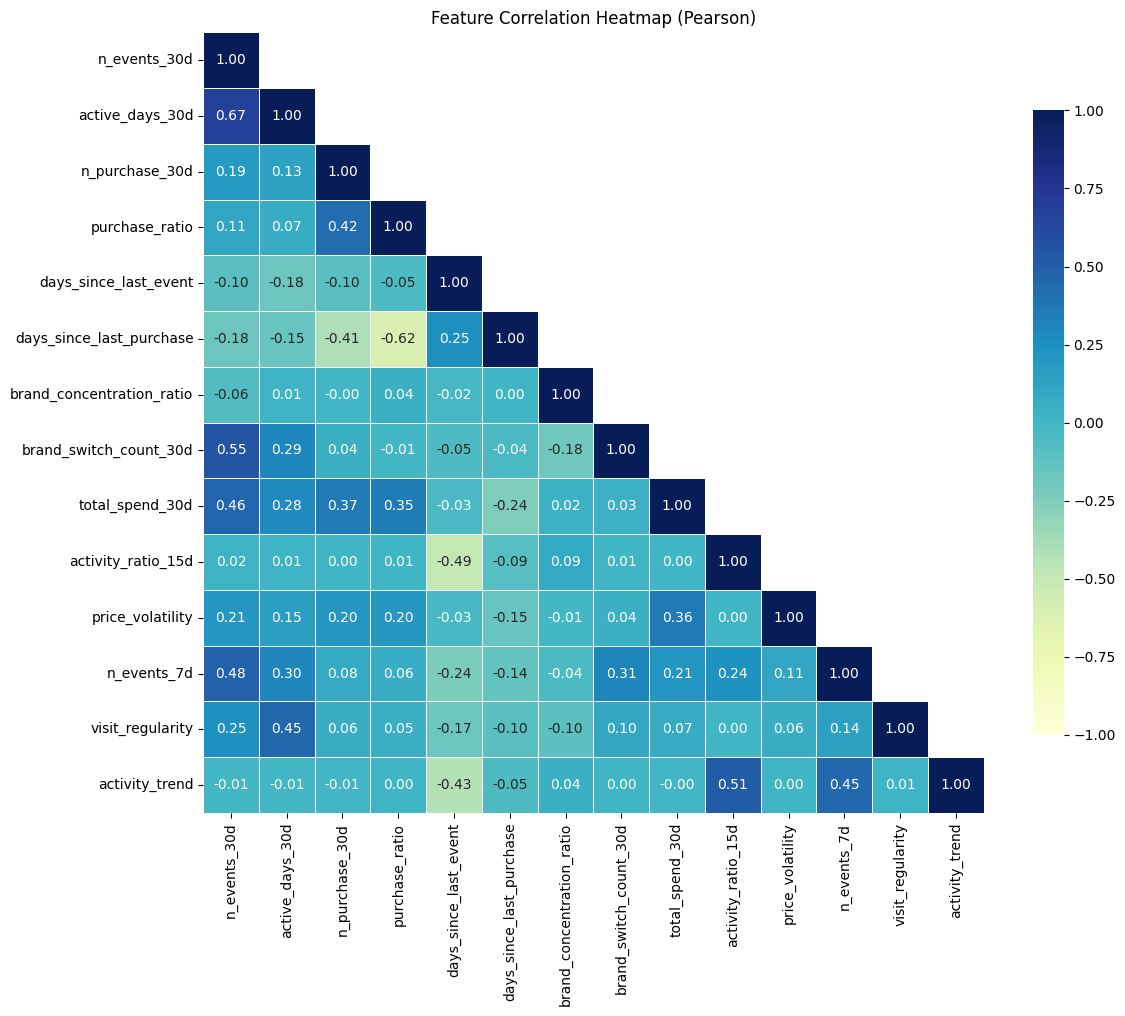

In [10]:
# 상관 히트맵 (선택)
try:
    import seaborn as sns
    import matplotlib.pyplot as plt

    corr = X.corr(method="pearson")
    mask = np.triu(np.ones_like(corr, dtype=bool), k=1)  # 대각선은 보이고, 윗삼각형만 숨김

    plt.figure(figsize=(12, 10))
    sns.heatmap(
        corr, mask=mask,
        vmin=-1, vmax=1,
        annot=True, fmt=".2f",
        cmap="YlGnBu",
        square=True, linewidths=0.5,
        cbar_kws={"shrink": 0.8}
    )
    plt.title("Feature Correlation Heatmap (Pearson)")
    plt.tight_layout()
    plt.show()
except Exception as e:
    print("Skip heatmap:", e)


In [32]:
PROJECT_ROOT = Path(r"C:\Users\Playdata\skn_project\second_pjt")
DATA_DIR = PROJECT_ROOT / "data" / "processed"
BASE_DIR = PROJECT_ROOT / "data" / 'raw'
OUT_DIR  = PROJECT_ROOT / "models" / "eval" / "lg"
OUT_DIR.mkdir(parents=True, exist_ok=True)

PATHS = {
    "labels":   DATA_DIR / "labels.parquet",
    "features": DATA_DIR / "features_ml_clean.parquet",
    "anchors": DATA_DIR / "anchor.parquet",
    "base": BASE_DIR / "base.parquet",
    'scoring' : OUT_DIR / 'scoring.parquet'
}

labels = pd.read_parquet(PATHS['labels'])
feature = pd.read_parquet(PATHS['features'])
anchors = pd.read_parquet(PATHS['anchors'])
base = pd.read_parquet(PATHS['base'])
aa = pd.read_parquet(PATHS['scoring'])
aa_sorted = aa.sort_values("risk_score", ascending=False)
print(aa_sorted[["user_id", "anchor_time", "risk_score"]].head(20)) 
# print(base.head(5))
# print(feature.head(5))
# print(labels.head(5))
# print(anchors.head(5))


         user_id anchor_time  risk_score
54983  573096859  2020-03-31    0.944700
85339  622358971  2020-03-31    0.944700
60147  584301560  2020-03-31    0.944692
60416  584797434  2020-03-31    0.944688
85349  622366290  2020-03-31    0.944675
85350  622366296  2020-03-31    0.944675
80726  616913666  2020-03-31    0.944673
59771  583522566  2020-03-31    0.944658
61859  587848687  2020-03-31    0.944656
85354  622369718  2020-03-31    0.944656
71948  603966347  2020-03-31    0.944652
62103  588280000  2020-03-31    0.944652
14530  516113433  2020-03-31    0.944649
85359  622371505  2020-03-31    0.944648
49362  565407332  2020-03-31    0.944645
32027  535414580  2020-03-31    0.944645
1369   512542169  2020-03-31    0.944644
68090  597969465  2020-03-31    0.944644
25953  524748914  2020-03-31    0.944642
58006  579771146  2020-03-31    0.944641


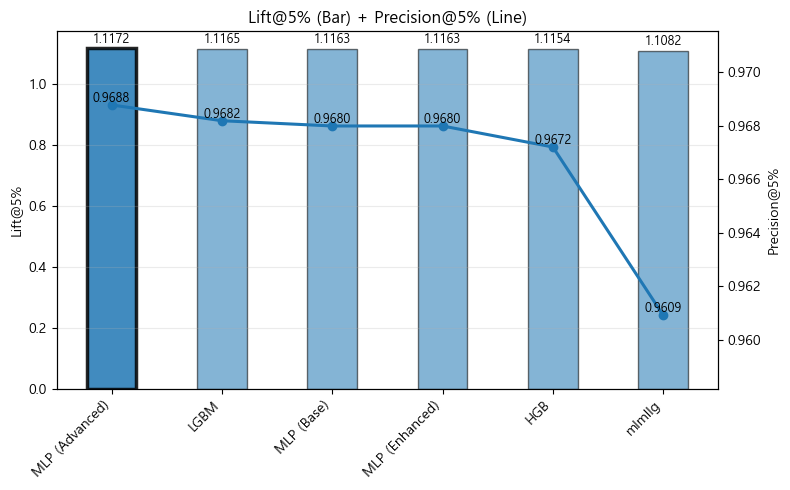

In [75]:
import os, glob, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

EVAL_ROOT = r"C:\Users\Playdata\skn_project\second_pjt\models\eval"

KEY_PREC = "상위 5% 정밀도 (Precision)"
KEY_LIFT = "상위 5% 리프트 (Lift)"

# ---- load ----
rows = []
for model_dir in sorted(glob .glob(os.path.join(EVAL_ROOT, "*"))):
    fp = os.path.join(model_dir, "metrics.json")
    if not os.path.exists(fp):
        continue
    with open(fp, "r", encoding="utf-8") as f:
        data = json.load(f)
    rows.append({
        "model": os.path.basename(model_dir),
        "precision_5": float(data.get(KEY_PREC)),
        "lift_5": float(data.get(KEY_LIFT)),
    })

dfp = pd.DataFrame(rows).dropna()
dfp = dfp.sort_values("lift_5", ascending=False).reset_index(drop=True)
NAME_MAP = {
    "dlmlp_advanced": "MLP (Advanced)",
    "dlmlp_base": "MLP (Base)",
    "dlmlp_enhance": "MLP (Enhanced)",
    "mlhgb": "HGB",
    "mllgbm": "LGBM",
    "mlmlg": "LogReg",
}
dfp["model_disp"] = dfp["model"].map(NAME_MAP).fillna(dfp["model"])

x = np.arange(len(dfp))

# ---- figure ----
fig, ax1 = plt.subplots(figsize=(8, 5))

# Bar styling (thin bars)
bar_width = 0.45
bars = ax1.bar(
    x,
    dfp["lift_5"].values,
    width=bar_width,
    alpha=0.55,              # 연하게
    edgecolor="black",       # 테두리
    linewidth=1.0
)
ax1.set_ylabel("Lift@5%")
ax1.set_xticks(x)
ax1.set_xticklabels(dfp["model_disp"].values, rotation=45, ha="right")

# 1등 모델 막대 강조
bars[0].set_alpha(0.85)
bars[0].set_linewidth(2.5)

# Lift 라벨(막대 위)
ax1.bar_label(
    bars,
    labels=[f"{v:.4f}" for v in dfp["lift_5"].values],
    padding=2,
    fontsize=9
)

# Line styling (different style)
ax2 = ax1.twinx()
ax2.plot(
    x,
    dfp["precision_5"].values,
    linestyle="-",
    linewidth=2.2,
    marker="o",
    markersize=6
)
ax2.set_ylabel("Precision@5%")

# Precision 라벨(점 위)
for xi, yi in zip(x, dfp["precision_5"].values):
    ax2.text(xi, yi, f"{yi:.4f}", ha="center", va="bottom", fontsize=9)

# Precision 축 zoom (근소 차이 보기 좋게)
pmin, pmax = dfp["precision_5"].min(), dfp["precision_5"].max()
ppad = (pmax - pmin) * 0.35 if pmax > pmin else 0.001
ax2.set_ylim(pmin - ppad, pmax + ppad)

# 제목 + 그리드
ax1.set_title("Lift@5% (Bar) + Precision@5% (Line)")
ax1.grid(axis="y", alpha=0.25)

plt.tight_layout()
plt.show()
